In [1]:
from snake_ai.envs import RandomObstaclesEnv
from snake_ai.diffsim import DiffusionSolver
import snake_ai.utils.visualization as vis

import taichi as ti
import warp as wp
import warp.sim as sim

import tqdm
import numpy as np
import phi.flow as pf
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

pygame 2.4.0 (SDL 2.26.5, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
[Taichi] version 1.6.0, llvm 15.0.4, commit f1c6fbbd, linux, python 3.10.11


[I 04/22/24 10:40:03.513 1205] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout
/home/rcremese/projects/snake-ai/src/snake_ai/diffsim/walk_simulation.py:93: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


# Presentation of the environment

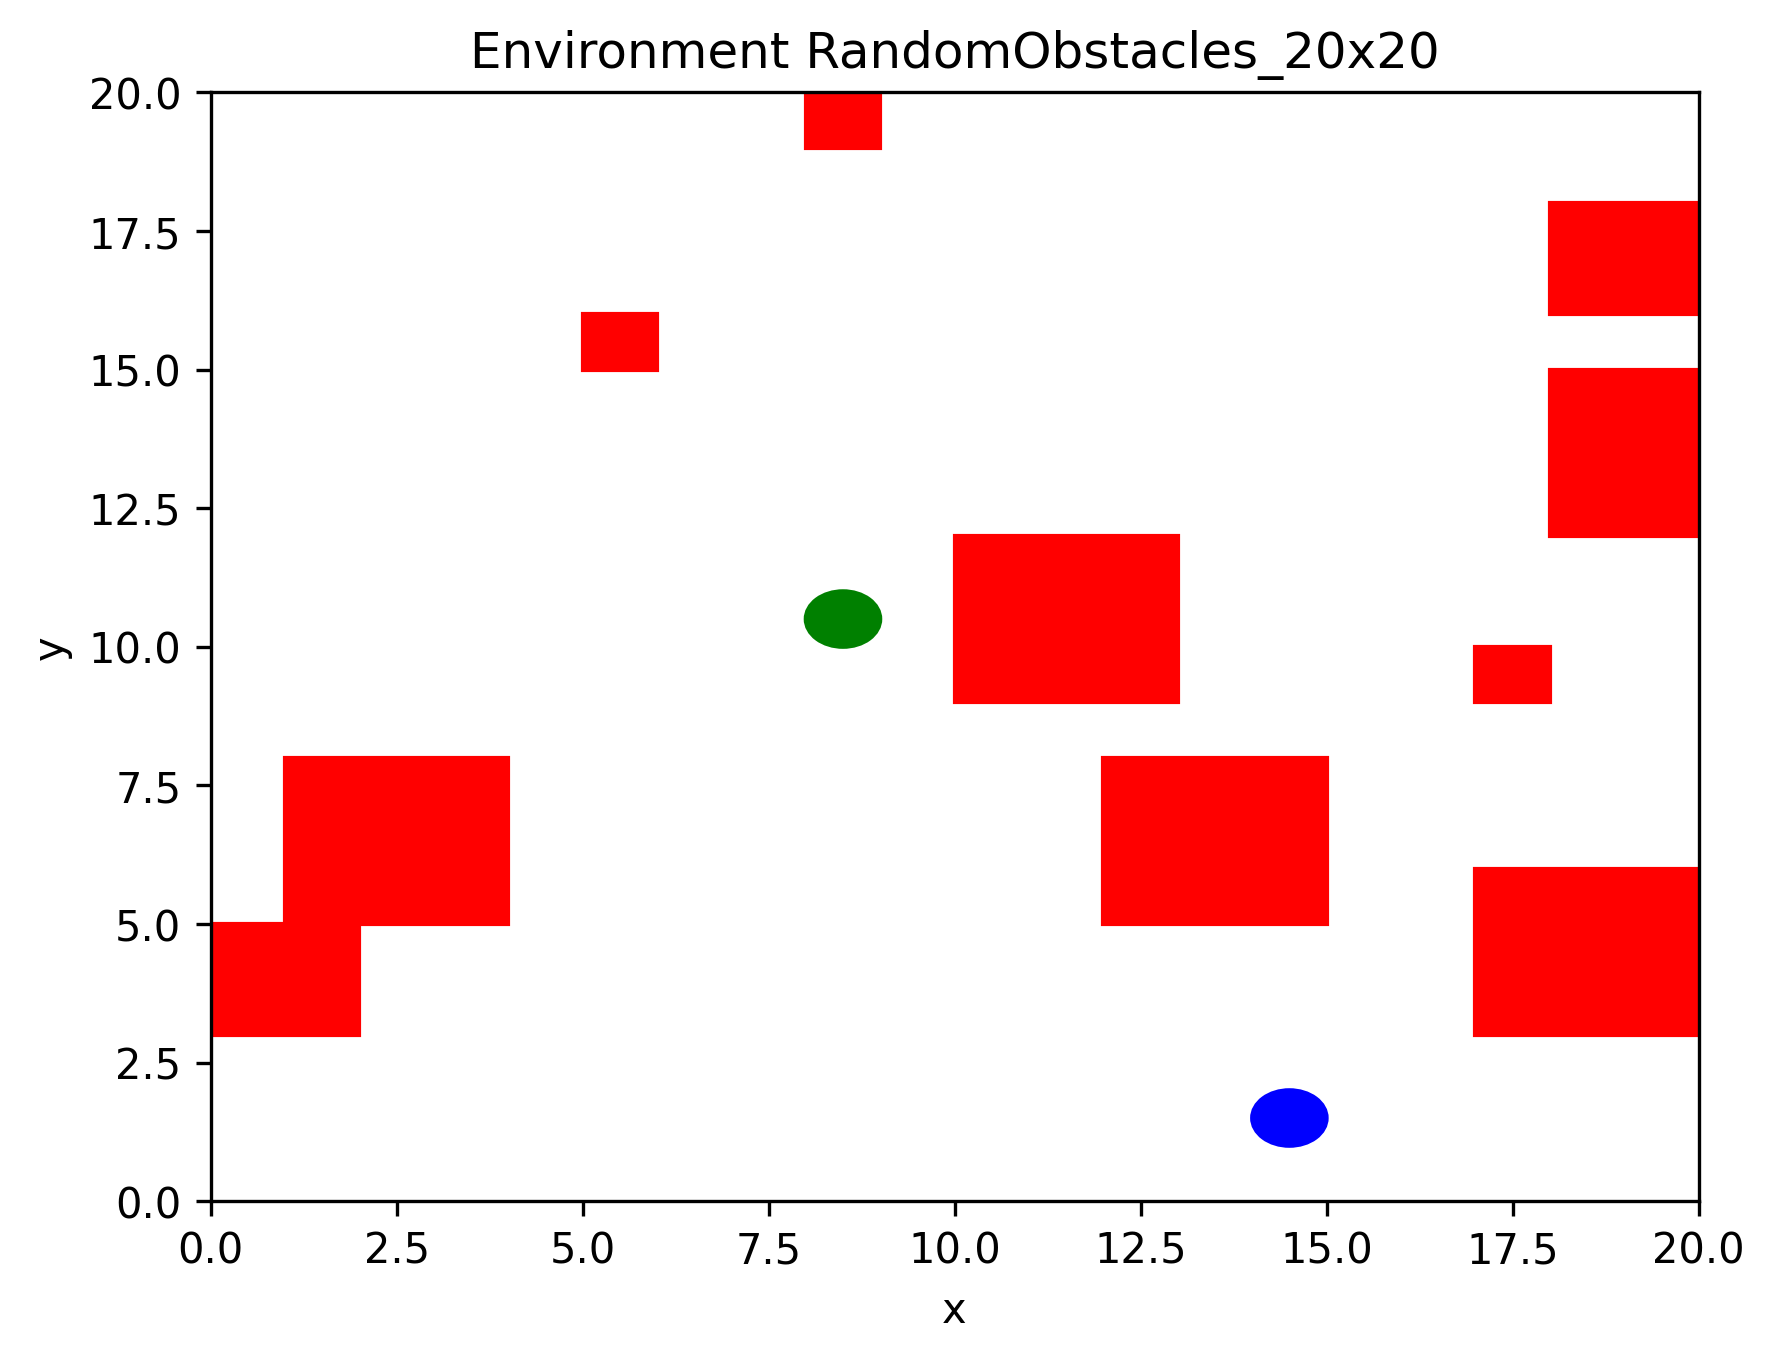

In [2]:
env = RandomObstaclesEnv(pixel=1, nb_obs=10, max_obs_size=3, seed=10)
env.reset()
fig = vis.Visualizer.plot_2D_environment(env)

# Definition of a force field associated to the environment

In [3]:
def create_laplacian_matrix_2d(
    nx: int, ny: int, dx: float, dy: float
) -> sp.lil_array:
    Dxx = sp.diags([1, -2, 1], [-1, 0, 1], shape=(nx, nx)) / dx**2
    Dyy = sp.diags([1, -2, 1], [-1, 0, 1], shape=(ny, ny)) / dy**2
    return sp.kronsum(Dyy, Dxx, format="csr")

In [4]:
# Definition of functions to convert between indices and subscripts
def ind2sub_2D(array_shape, ind):
    rows = (ind / array_shape[1])
    cols = ind % array_shape[1]
    return np.array([rows, cols], dtype='int')

def sub2ind_2D(array_shape, rows, cols):
    return int(rows*array_shape[1] + cols)

In [5]:
def apply_dirichlet_2D(A: sp.spmatrix, binary_map: np.ndarray):
    """Apply the Dirichlet boundary conditions to the linear system.

    Args:
        A (sp.spmatrix): Sparse matrix of the linear system Ax = b
        binary_map (np.ndarray): binary map of the domain, where 1 correspond to spaces to apply the boundary conditions 
    """
    res = binary_map.shape
    max_index = np.prod(res)
    rhs = np.zeros(max_index)
    assert A.shape == (max_index, max_index), "Shape mismatch between the matrix and the binary map"  

    rows, cols = np.nonzero(binary_map)   
    for i, j in tqdm.tqdm(zip(rows, cols), total=len(rows)):
        index = sub2ind_2D(res, i, j)
        
        A[index, index] = 1
        rhs[index] = binary_map[i, j]
        
        ind_o = sub2ind_2D(res, i + 1, j)
        ind_e = sub2ind_2D(res, i - 1, j)
        ind_n = sub2ind_2D(res, i, j + 1)
        ind_s = sub2ind_2D(res, i, j - 1)
        
        for neighbour_ind in [ind_o, ind_e, ind_n, ind_s]:
            # Set the row to the identity vector and apply the colums to rhs
            if neighbour_ind >= 0 and neighbour_ind < max_index:
                A[index, neighbour_ind] = 0
                rhs[neighbour_ind] -= A[neighbour_ind, index] * rhs[index]
                A[neighbour_ind, index] = 0
    return A, rhs

<class 'phi.field._point_cloud.PointCloud'>


<Figure size 1200x500 with 1 Axes>

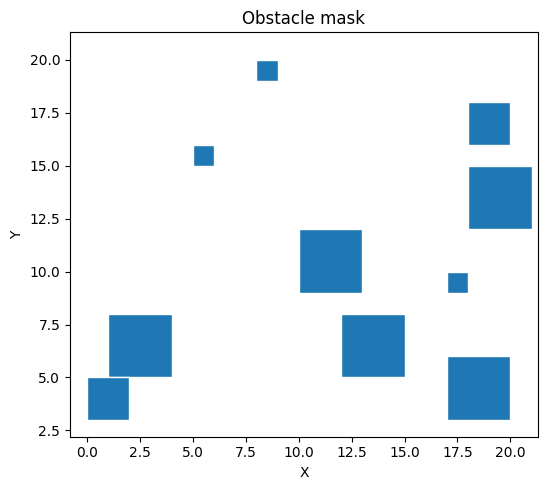

In [6]:
res = 4
def convert_obstacles_to_geometry(obstacles):
    # Handle the case where there is only one obstacle
    return [
        pf.Box(
            x=(obs.left, obs.right),
            y=(obs.top, obs.bottom),
        )
        for obs in obstacles
    ]
obstacle_list = convert_obstacles_to_geometry(env.obstacles)
obstacle_mask = pf.mask(pf.union(obstacle_list))
print(type(obstacle_mask))
pf.vis.plot(pf.union(obstacle_list), title='Obstacle mask')


<Figure size 1200x500 with 2 Axes>

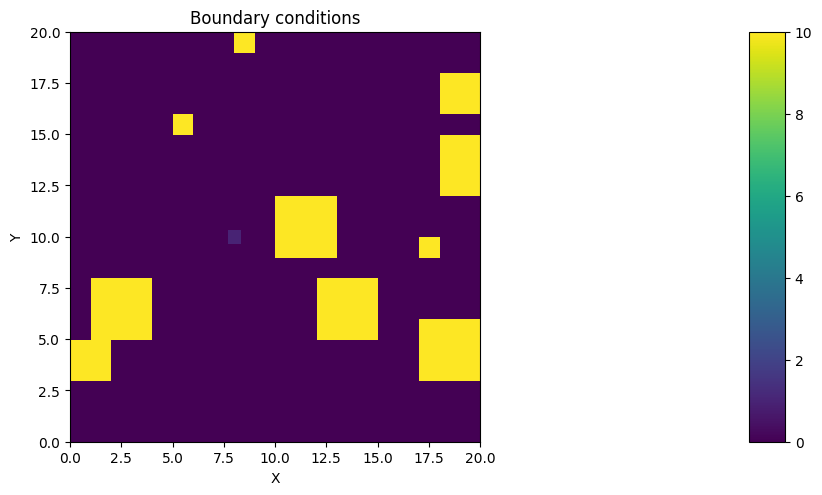

In [7]:
bounds = pf.Box(x=env.width, y=env.height)
goal = pf.Sphere(x=env.goal.centerx, y=env.goal.centery, radius=env.goal.width/2)

resolution = 3

boundary_conditions = pf.CenteredGrid(0, bounds=bounds, extrapolation=10, resolution=pf.spatial(x=env.width * resolution, y= env.height * resolution))
boundary_conditions = pf.field.where(pf.mask(goal), 1, boundary_conditions)
boundary_conditions = pf.field.where(obstacle_mask, 10, boundary_conditions)
pf.vis.plot(boundary_conditions, title='Boundary conditions')

In [8]:
def solve_concentration(boundary_conditions : pf.CenteredGrid):
    bc_values = boundary_conditions.values.numpy('x,y')
    bc_values[0,:] = bc_values[-1,:] = bc_values[:,0] = bc_values[:,-1] = 10
    res = bc_values.shape
    step = boundary_conditions.dx.numpy()

    laplace_matrix = create_laplacian_matrix_2d(*res, *step)
    laplace_matrix, rhs = apply_dirichlet_2D(laplace_matrix, bc_values)
    
    solution : np.ndarray = splinalg.spsolve(laplace_matrix, rhs)
    concentration = boundary_conditions.with_values(pf.tensor(solution.reshape(res), pf.spatial('x,y')))   
    return concentration

In [9]:
concentration = solve_concentration(boundary_conditions)

  0%|          | 0/684 [00:00<?, ?it/s]/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
100%|██████████| 684/684 [00:00<00:00, 2847.79it/s]


/home/rcremese/mambaforge/envs/snake-env/lib/python3.10/site-packages/phi/math/backend/_backend.py:1480: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


<Figure size 1200x500 with 1 Axes>

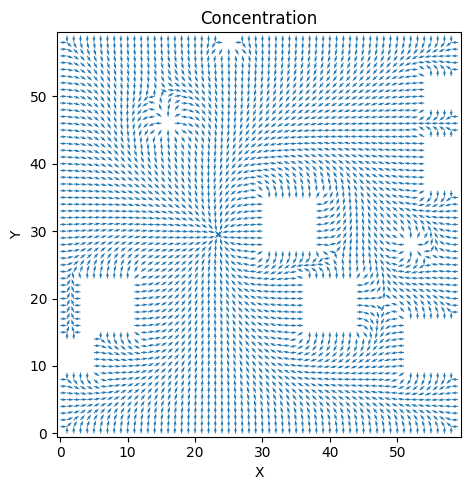

In [10]:
force_field = pf.field.spatial_gradient(concentration)
# pf.field.normalize(force_field, concentration.with_values(1), epsilon=1e-5)
force = pf.math.vec_normalize(-force_field.values)
pf.vis.plot(force, title='Concentration')

# Simulation differentiable warp 

In [14]:
@wp.kernel
def loss_l2(
    states: wp.array2d(dtype=wp.float32), targets: wp.array2d(dtype=wp.float32), loss: wp.array(dtype=wp.float32)
):
    i, j = wp.tid()
    diff = states[i, j] - targets[i, j]
    l = diff * diff
    wp.atomic_add(loss, 0, l)
 
@wp.struct
class VectorField2D():
    x: wp.array2d(dtype=wp.float32)
    y: wp.array2d(dtype=wp.float32)
    bmin : wp.vec2
    bmax : wp.vec2
    step : wp.vec2

@wp.kernel
def evaluate_force_field(
    force_field: VectorField2D, position : wp.array(dtype=wp.vec2), evaluation: wp.array(dtype=wp.vec2)
):
    n = wp.tid()
    pos = position[n]
    i = int((pos[0] - force_field.bmin[0]) / force_field.step[0])
    j = int((pos[1] - force_field.bmin[1]) / force_field.step[1])
    
    if (i < 0) or (i >= force_field.x.shape[0]) or (j < 0) or (j >= force_field.x.shape[1]):
        evaluation[n] = wp.vec2(0., 0.)
    else:
        evaluation[n] = wp.vec2(
            force_field.x[i, j],
            force_field.y[i, j]
        )

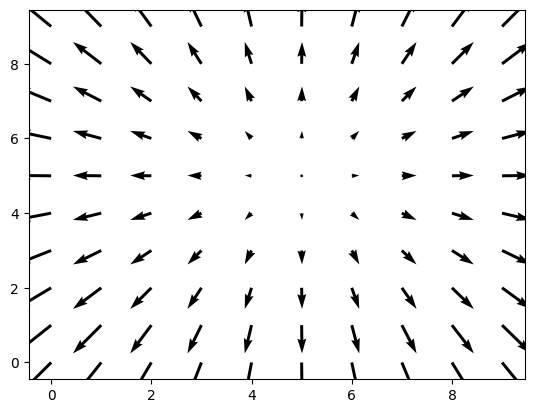

In [37]:
field = VectorField2D()
wp.init()
X, Y = np.mgrid[-1:1:100j, -1:1:100j]
plt.quiver(Y[::10,::10], X[::10,::10])
# fx, fy = force_field.values.numpy('vector,x,y')
# field.x = wp.array(fx)
# field.y = wp.array(fy)
# field.bmin = wp.vec2(0., 0.)
# field.bmax = wp.vec2(env.width, env.height)
# field.step = wp.vec2(env.width / res, env.height / res)

In [31]:
value = wp.empty(shape=(2,), dtype=wp.vec2)
init_pos = wp.array([wp.vec2(0.5, 0.5),wp.vec2(9.5, 9.5)], dtype=wp.vec2)
wp.launch(evaluate_force_field, 2, inputs=[field, init_pos, value])

In [32]:
value.numpy()

array([[ 0.        ,  0.        ],
       [-0.00202417, -0.0018754 ]], dtype=float32)

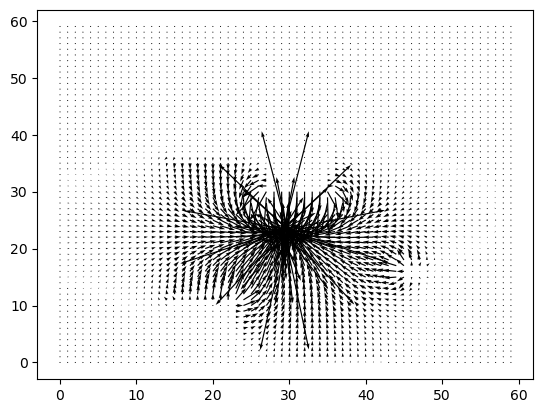

In [69]:
import warp as wp
import numpy as np
from warp import sim
from warp.optim import SGD, Adam


@wp.kernel
def init_velocity(
    particle_qd: wp.array(dtype=wp.vec3),
    action: wp.array(dtype=wp.vec2),
):
    n = wp.tid()
    # print(particle_qd[n])
    # print(action[n])

    vel = particle_qd[n] + wp.vec3(action[n][0], action[n][1], 0.0)
    particle_qd[n] = vel


@wp.kernel
def apply_gravity(
    particle_q: wp.array(dtype=wp.vec3),
    particle_f: wp.array(dtype=wp.vec3),
):
    n = wp.tid()
    pos = particle_q[n]

    radius_sq = wp.length_sq(pos)
    angle = wp.atan2(pos[1], pos[0])

    gravity = -9.18 / radius_sq * wp.normalize(pos)
    particle_f[n] = gravity


@wp.kernel
def loss_l2(
    particle_q: wp.array(dtype=wp.vec3),
    target_dist: float,
    loss: wp.array(dtype=wp.float32),
):
    n = wp.tid()
    pos = particle_q[n]
    dist = wp.length(pos) - target_dist
    l = dist * dist
    wp.atomic_add(loss, 0, l)


class GravitationalExample:
    def __init__(
        self,
        tmax,
        nb_part: int = 1,
        init_dist: float = 10.0,
        target: float = 5.0,
        verbose: bool = False,
    ) -> None:
        self.verbose = verbose
        self.frame_dt = 1.0 / 60.0
        self.episode_frames = tmax

        self.sim_substeps = 1
        self.sim_dt = self.frame_dt / self.sim_substeps

        self.render_time = 0.0

        self.iter = 0

        assert nb_part > 0, "The number of particles must be greater than 0."
        self.nb_part = nb_part
        builder = sim.ModelBuilder(gravity=0.0)

        angles = np.linspace(0, 2 * np.pi, nb_part, endpoint=False)
        init_pos = np.array([np.cos(angles), np.sin(angles)]) * init_dist
        init_vel = np.array([-np.sin(angles), np.cos(angles)]) * 1.0

        for n in range(nb_part):
            builder.add_particle(
                pos=wp.vec3(init_pos[0, n], init_pos[1, n], 0.0),
                vel=wp.vec3(init_vel[0, n], init_vel[1, n], 0.0),
                mass=1.0,
                radius=1.0,
            )

        assert target > 0, "The target distance must be greater than 0."
        self.target_dist = target

        # finalize model
        self.model = builder.finalize(requires_grad=True)

        self.builder = builder
        self.model.ground = False

        self.dof_q = self.model.joint_coord_count
        self.dof_qd = self.model.joint_dof_count
        self.num_bodies = self.model.body_count

        # Only take control of the angular velocity
        self.action_dim = 1
        self.state_dim = 2

        # Define an integrator
        self.integrator = sim.SemiImplicitIntegrator()

        # initial guess
        self.actions = wp.zeros(
            shape=self.nb_part,
            dtype=wp.vec2,
            requires_grad=True,
        )

        self.renderer = None

        # allocate sim states for trajectory
        self.states = []
        for _ in range(self.episode_frames + 1):
            self.states.append(self.model.state())

        # allocate sim states for trajectory
        self.optimizer = SGD([self.actions], lr=1e-3)
        self.loss = wp.zeros(1, dtype=wp.float32, requires_grad=True)

    def forward(self):
        """
        Advances the system dynamics given the rigid-body state in maximal coordinates and generalized joint torques
        [body_q, body_qd, tau].
        """
        wp.launch(
            init_velocity,
            self.nb_part,
            inputs=[
                self.states[0].particle_qd,
                self.actions,
            ],
        )
        for i in range(self.episode_frames):
            state = self.states[i]

            for _ in range(self.sim_substeps):
                next_state = self.model.state(requires_grad=True)

                sim.collide(self.model, state)

                # apply generalized torques to rigid body here, instead of planar joints
                wp.launch(
                    apply_gravity,
                    self.nb_part,
                    inputs=[state.particle_q],
                    outputs=[state.particle_f],
                )

                state = self.integrator.simulate(
                    self.model, state, next_state, self.sim_dt
                )

            self.states[i + 1] = state

            # save state
            # wp.launch(save_state, dim=1, inputs=[self.states[i + 1].body_q, i], outputs=[self.last_traj])

        # compute loss
        wp.launch(
            loss_l2,
            dim=self.nb_part,
            inputs=[state.particle_q, self.target_dist, self.loss],
        )

    def step(self):
        """Runs a single optimizer iteration"""
        self.loss.zero_()

        tape = wp.Tape()
        with tape:
            self.forward()
        tape.backward(loss=self.loss)

        if self.verbose and (self.iter + 1) % 10 == 0:
            print(f"Iter {self.iter+1} Loss: {self.loss.numpy()[0]:.3f}")

        assert not np.isnan(self.actions.grad.numpy()).any(), "NaN in gradient"

        self.optimizer.step([self.actions.grad])
        tape.zero()
        self.iter = self.iter + 1


if __name__ == "__main__":
    import matplotlib.pyplot as plt

    wp.init()
    wp.set_device("cpu")
    example = GravitationalExample(tmax=10_000, nb_part=25, target=100.0, verbose=True)
    # Optimize
    num_iter = 50
    example.forward()
    # for i in range(num_iter):
    #     example.step()

    # Visualize
    positions = np.stack([state.particle_q.numpy() for state in example.states], axis=1)
    for pos in positions:
        plt.plot(pos[:, 0], pos[:, 1])
    plt.show()


In [ ]:
class DiffApf2D():
    def __init__(self, init_pos : np.ndarray, force_field : ) -> None:
        pass